# Deep Q-Network (DQN)
---
In this notebook, you will implement a DQN agent with OpenAI Gym's LunarLander-v2 environment.

### 1. Import the Necessary Packages

In [1]:
import gymnasium as gym
#!pip3 install box2d
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    print("Ipython")
    from IPython import display
else:
    print("pyvirtualdisplay")
    #!python -m pip install pyvirtualdisplay
    from pyvirtualdisplay import Display
    display = Display(visible=0, size=(1400, 900))
    display.start()
ion_context = plt.ion()

from DQN_agent import *
from DQN_utils import *
print("Using device", device, "imported from DQN_utils.")
    

Ipython
Using device cuda:0 imported from DQN_utils.


### 2. Instantiate the Environment and Agent

Initialize the environment in the code cell below.

State shape:  8
Number of actions:  4
2 -2.843 False


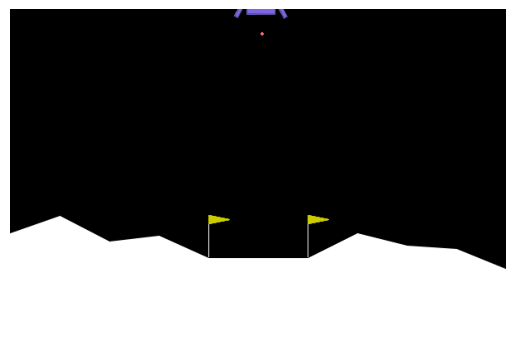

In [2]:
##### NEW GYM = GYMNASIUM
#!pip install gymnasium[box2d]
#import gymnasium as gym
env = gym.make("LunarLander-v2", render_mode="rgb_array",    #"human",       #
                                 continuous= False,
                                 gravity= -9.81,
                                 enable_wind= True,
                                 wind_power= 3.14,
                                 turbulence_power= 0.1)

state, info = env.reset(seed = SEED)
action = env.action_space.sample()  # agent policy that uses the observation and info
state, reward, done, trun, info = env.step(action)

state_shape = env.observation_space.shape
state_size = state_shape[0]
action_size = env.action_space.n
print('State shape: ', state_size)
print('Number of actions: ', action_size)
print(action, round(reward, 3), done or trun)
plt.axis('off')
plt.imshow(pix_norm(env.render()))

Please refer to the instructions in `Deep_Q_Network.ipynb` if you would like to write your own DQN agent.  Otherwise, run the code cell below to load the solution files.

In [4]:
#from dqn_agent import Agent
if False:
    agent = Agent(state_size=8, action_size=4, seed=0)

    # watch an untrained agent
    state = env.reset()
    img = plt.imshow(env.render(mode='rgb_array'))
    for j in range(200):
        action = agent.act(state)
        img.set_data(env.render(mode='rgb_array')) 
        plt.axis('off')
        display.display(plt.gcf())
        display.clear_output(wait=True)
        state, reward, done, _ = env.step(action)
        if done:
            break 

    env.close()

### 3. Train the Agent with DQN

Run the code cell below to train the agent from scratch.  You are welcome to amend the supplied values of the parameters in the function, to try to see if you can get better performance!

Alternatively, you can skip to the next step below (**4. Watch a Smart Agent!**), to load the saved model weights from a pre-trained agent.

In [5]:
#agent = Agent(state_size=state_size, action_size=action_size, seed=SEED, fc1_units=128, fc2_units=128)

In [6]:
#agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))
#agent.fc1_units, agent.fc2_units, agent.steps

In [22]:
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    FIRST = True
    episode_lengths = []
    scores = []                        # list containing scores from each episode
    window_size = 100                  # scores to rolling-remember
    scores_window = deque(maxlen=window_size)
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state, _ = env.reset(seed=SEED)
        score = 0
        episteps = 0
        for t in range(max_t):  #episteps):
            action = agent.act(state, eps)
            next_state, reward, done, trun, _ = env.step(action)
            agent.step(state, action, reward, next_state, done or trun)
            state = next_state
            score += reward
            episteps += 1
            if done or trun:
                break 
                
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        episode_lengths.append(episteps)
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        
        cycle_steps = agent.steps%BUFFER_SIZE
        buffer_cycle = agent.steps//BUFFER_SIZE

        print("\rEpisode {0:d} | Average Score:{:8.2f} | Epsilon:{:2.3f} | Max Steps:{:5d} | Buffer cycle:{:7d} +{:3d}".format(i_episode, 
                                                                                                                            np.mean(scores_window), 
                                                                                                                            eps,
                                                                                                                            episteps,
                                                                                                                            cycle_steps,
                                                                                                                            buffer_cycle), end="")
                                                                                                                                        
        if i_episode % 100 == 0:
            chkpntname = "data/chkpnt{}.pth".format(i_episode)
            torch.save(agent.qnetwork_local.state_dict(), chkpntname)   
            print("\rEpisode {:4d} | Average Score: {:7.2f} | Epsilon: {:1.3f} | Max Steps: {:4d} | Buffer cycle:{:7d} +{:3d}".format(i_episode, 
                                                                                                                            np.mean(scores_window), 
                                                                                                                            eps,
                                                                                                                            episteps,
                                                                                                                            cycle_steps,
                                                                                                                            buffer_cycle))
        #episteps = (episteps - 1) if episteps>=100 else max_t
        
        if np.mean(scores_window)>=200. and FIRST:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:5.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'data/slvdpnt.pth')
            FIRST = False
        elif np.mean(scores_window)>=250. :
            print("\n***** High Score! *****")
            pprint("\tGame over.")
            torch.save(agent.qnetwork_local.state_dict(), 'data/hipnt.pth')
            break
             
    return scores, episode_lengths


In [15]:
agent = Agent(state_size=8, action_size=4, seed=SEED, fc1_units=128, fc2_units=128)
#cycle_steps = 1000011%BUFFER_SIZE
#buffer_cycle = 1000011//BUFFER_SIZE
#cycle_steps, buffer_cycle

In [24]:
#agent.memory.memory.clear()
#agent.steps=0
scores, episode_lengths = dqn(n_episodes=1000, max_t=1000, eps_start=1.0, eps_end=0.005, eps_decay=0.995)

Episode  100 | Average Score: -149.02 | Epsilon: 0.606 | Max Steps:  112 | Buffer cycle:  12025 +  0
Episode  200 | Average Score:  -51.05 | Epsilon: 0.367 | Max Steps:  148 | Buffer cycle:  29664 +  0
Episode  300 | Average Score:   62.01 | Epsilon: 0.222 | Max Steps: 1000 | Buffer cycle:  91266 +  0
Episode  400 | Average Score:  172.55 | Epsilon: 0.135 | Max Steps:  563 | Buffer cycle: 160892 +  0
Episode  419 | Average Score:  200.74 | Epsilon:0.122 | Max Steps:  836 | Buffer cycle: 174572 +  0
Environment solved in 319 episodes!	Average Score: 200.74
Episode  500 | Average Score:  222.13 | Epsilon: 0.082 | Max Steps:  297 | Buffer cycle: 224534 +  0
Episode  600 | Average Score:  238.04 | Epsilon: 0.049 | Max Steps:  442 | Buffer cycle:  26778 +  1
Episode  659 | Average Score:  250.03 | Epsilon:0.037 | Max Steps:  328 | Buffer cycle:  54382 +  1
High Score!


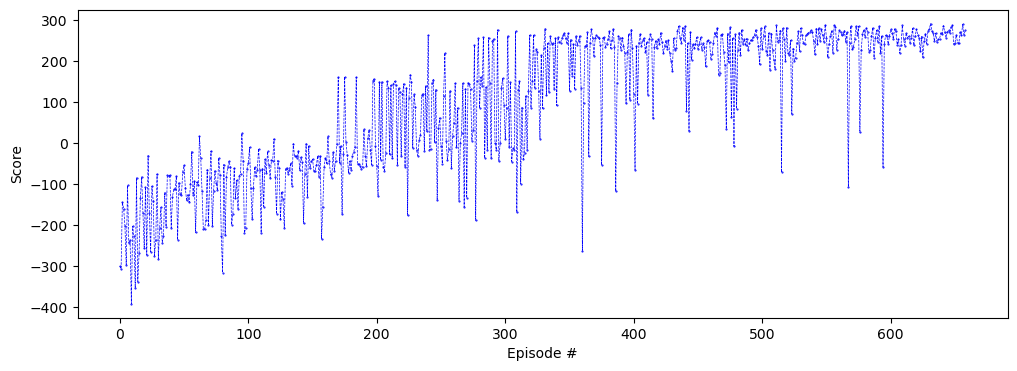

In [27]:
# plot the scores
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, 'b.--', linewidth=0.5, markersize=1.0)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

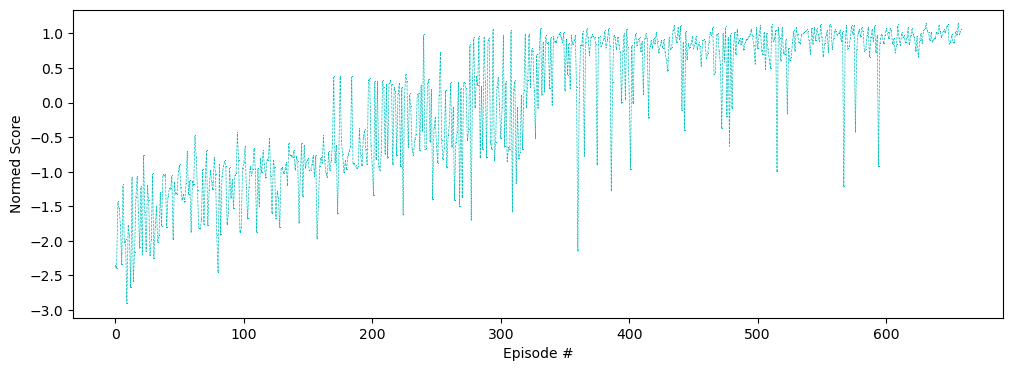

In [31]:
# plot the normed scores
norm = lambda x: (x - np.mean(x))/np.std(x) if np.std(x)!=0. else 0.
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), norm(np.asarray(scores)), 'c,--', linewidth=0.5, markersize=1.0,)
plt.ylabel('Normed Score')
plt.xlabel('Episode #')
plt.show()

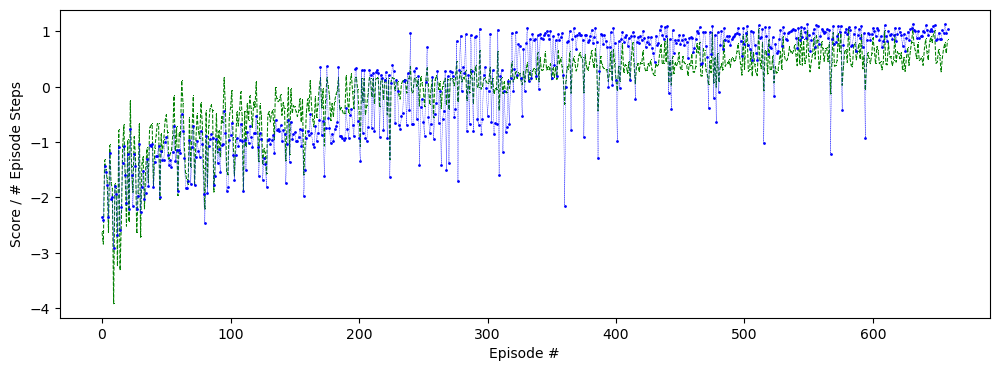

In [34]:
# plot the episode_steps
#norm = lambda x: (x - np.mean(x))/np.std(x) if np.std(x)!=0. else 0.
score_per_step = [s/el for s, el in zip(scores,episode_lengths)]
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(111)
plt.plot(np.arange(len(episode_lengths)), score_per_step, 'g,--', linewidth=0.75, markersize=1.0,)
plt.plot(np.arange(len(scores)), norm(np.asarray(scores)), 'bo--', linewidth=0.25, markersize=1.0,)
plt.ylabel('Score / # Episode Steps')
plt.xlabel('Episode #')
plt.show()

In [19]:
experiences = agent.memory.memory
states, actions, rewards, next_states, dones = disentangle(experiences)
states = np.asarray(states)
next_states = np.asarray(next_states)
rewards = np.asarray(rewards)
actions = np.asarray(actions)

In [ ]:
np.mean(states), np.std(states), np.min(states), np.max(states), states.shape

In [ ]:
np.mean(next_states), np.std(next_states), np.min(next_states), np.max(next_states), next_states.shape

In [ ]:
np.mean(actions), np.std(actions), np.min(actions), np.max(actions), actions.shape

In [20]:
np.mean(rewards), np.std(rewards), np.min(rewards), np.max(rewards), rewards.shape

(0.2023974030336332, 4.694961676584469, -100.0, 100.0, (250000,))

In [ ]:
BUFFER_SIZE

In [ ]:
# plot the states
fig = plt.figure(figsize=(16,4))plt.ylabel('States (high/low)')
plt.xlabel('Steps (s)')
plt.xlim(80000, 100000)

ax1 = fig.add_subplot(121)
plt.plot(np.arange(len(states)), states, linewidth=0.75, markersize=1.0)

ax2 = fig.add_subplot(122)
ax2.sharey(ax1)

ax.plot(np.arange(len(next_states)), next_states, linewidth=0.75, markersize=1.0)

plt.show()

### 4. Watch a Smart Agent!

In the next code cell, you will load the trained weights from file to watch a smart agent!

In [ ]:
# load the weights from file
#agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

# watch a pre-trained agent

#for chkpnt in range(100,1300,300):
for chkpnt in [100,400,700,1000]:    
    chkpnt_name = "data/chkpnt{}.pth".format(chkpnt)
    agent.qnetwork_local.load_state_dict(torch.load(chkpnt_name))
    score = 0
    state, _ = env.reset()
    img = plt.imshow(env.render())
    for j in range(1000):
        action = agent.act(state)
        state, reward, done, trun, _ = env.step(action)
        score += reward
        img.set_data(env.render()) 
        plt.axis('off')
        title = "{:4d} | {:5d} | {:7.2f} | {:6s}".format(chkpnt, j+1, score, num2act[action])
        plt.title(title)
        display.display(plt.gcf())
        display.clear_output(wait=True)
        if done or trun:
            break 
      
#env.close()

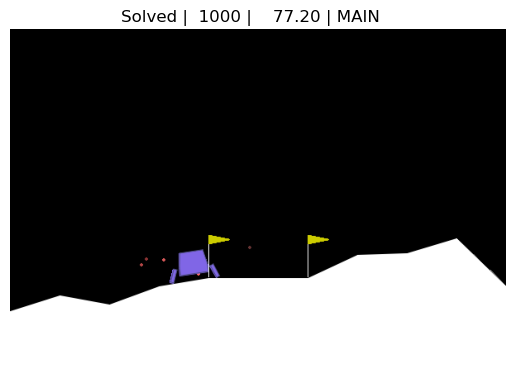

In [14]:
chkpnt_name = "data/slvdpnt.pth"#"data/chkpnt{}.pth".format(chkpnt)  #
agent.qnetwork_local.load_state_dict(torch.load(chkpnt_name))
score = 0
state, _ = env.reset()
img = plt.imshow(env.render())
for j in range(1000):
    action = agent.act(state)
    state, reward, done, trun, _ = env.step(action)
    score += reward
    img.set_data(env.render()) 
    plt.axis('off')
    title = "{:6s} | {:5d} | {:8.2f} | {:7s}".format("Solved", j+1, score, num2act[action])
    plt.title(title)
    display.display(plt.gcf())
    display.clear_output(wait=True)
    if done or trun:
        break 

### 5. Explore

In this exercise, you have implemented a DQN agent and demonstrated how to use it to solve an OpenAI Gym environment.  To continue your learning, you are encouraged to complete any (or all!) of the following tasks:
- Amend the various hyperparameters and network architecture to see if you can get your agent to solve the environment faster.  Once you build intuition for the hyperparameters that work well with this environment, try solving a different OpenAI Gym task with discrete actions!
- You may like to implement some improvements such as prioritized experience replay, Double DQN, or Dueling DQN! 
- Write a blog post explaining the intuition behind the DQN algorithm and demonstrating how to use it to solve an RL environment of your choosing.  

In [ ]:
def DELETE_dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state, _ = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, trun, _ = env.step(action)
            agent.step(state, action, reward, next_state, done or trun)
            state = next_state
            score += reward
            if done or trun:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            chkpnt_name = "data/target_chkpnt{}.pth".format(i_episode)
            torch.save(agent.qnetwork_target.state_dict(), chkpnt_name)
        if np.mean(scores_window)>=200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'data/solution_chkpnt.pth')
            break
    return scores



In [ ]:
for i in range(10):
    print(random.sample(range(5), k=4))